In [2]:
!mkdir -p ./kaggle
!cp kaggle.json ~/.kaggle/

cp: cannot create regular file '/root/.kaggle/': Not a directory


In [3]:
!kaggle datasets download -d msambare/fer2013

Dataset URL: https://www.kaggle.com/datasets/msambare/fer2013
License(s): DbCL-1.0
 96% 58.0M/60.3M [00:03<00:00, 24.6MB/s]
100% 60.3M/60.3M [00:03<00:00, 17.0MB/s]


In [4]:
import zipfile
zip_ref = zipfile.ZipFile('/content/fer2013.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [5]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import imghdr
import tensorflow as tf
from PIL import Image
import seaborn as sns

from sklearn.metrics import confusion_matrix,classification_report,roc_curve,auc
from sklearn.utils.class_weight import compute_class_weight

from tensorflow.keras import layers,regularizers,optimizers,models
from tensorflow.keras.applications import VGG16,ResNet50V2
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping,TensorBoard,ReduceLROnPlateau,CSVLogger
from tensorflow.keras.layers import Conv2D,MaxPooling2D,BatchNormalization,Dropout,Flatten,Dense,Activation
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.optimizers import Adam,Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img,img_to_array
from keras.utils import plot_model

In [6]:
project_name = 'Emotion Detection'

model_names = [
    'CNN',
    'CNN_with_Augmentation',
    'VGG16_transfer_learning',
    'ResNet50_transfer_learning'
]
base_dir = '/content/'

project_dir = os.path.join(base_dir,project_name)
os.makedirs(project_dir,exist_ok = True)

for each_model in model_names:
  model_dir = os.path.join(project_dir,each_model)
  os.makedirs(model_dir,exist_ok = True)

print(f'Project directory structure created at: {project_dir}')

Project directory structure created at: /content/Emotion Detection


In [7]:
image_exts = ['jpeg','jpg','png']

data_dir = '/content/train'

for root,dirs,files in os.walk(data_dir):
  for file in files:
    file_path = os.path.join(root,file)

    try:
      file_type = imghdr.what(file_path)

      if file_type not in image_exts:
        print(f'Image not in ext list {file_path}')
        os.remove(file_path)
      else:
        img = cv2.imread(file_path)

    except Exception as e:
      print(f'Issue with file{file_path}. Error: {e}')
      os.remove(file_path)

In [8]:
def count_files_in_subdirs(directory,set_name):
  counts={}

  for item in os.listdir(directory):
    item_path = os.path.join(directory,item)

    if os.path.isdir(item_path):
      counts[item] = len(os.listdir(item_path))

  df = pd.DataFrame(counts,index=[set_name])
  return df

train_dir = '/content/train'
test_dir = '/content/test'

train_count = count_files_in_subdirs(train_dir,'train')
print(train_count)

test_count = count_files_in_subdirs(test_dir,'test')
print(test_count)

       surprise  disgust  neutral  angry   sad  happy  fear
train      3171      436     4965   3995  4830   7215  4097
      surprise  disgust  neutral  angry   sad  happy  fear
test       831      111     1233    958  1247   1774  1024


<Axes: >

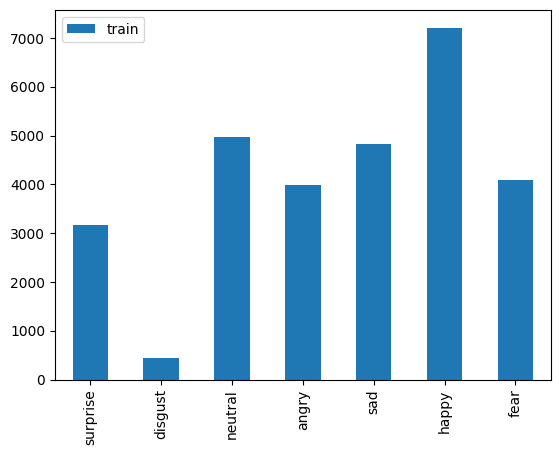

In [9]:
train_count.transpose().plot(kind='bar')

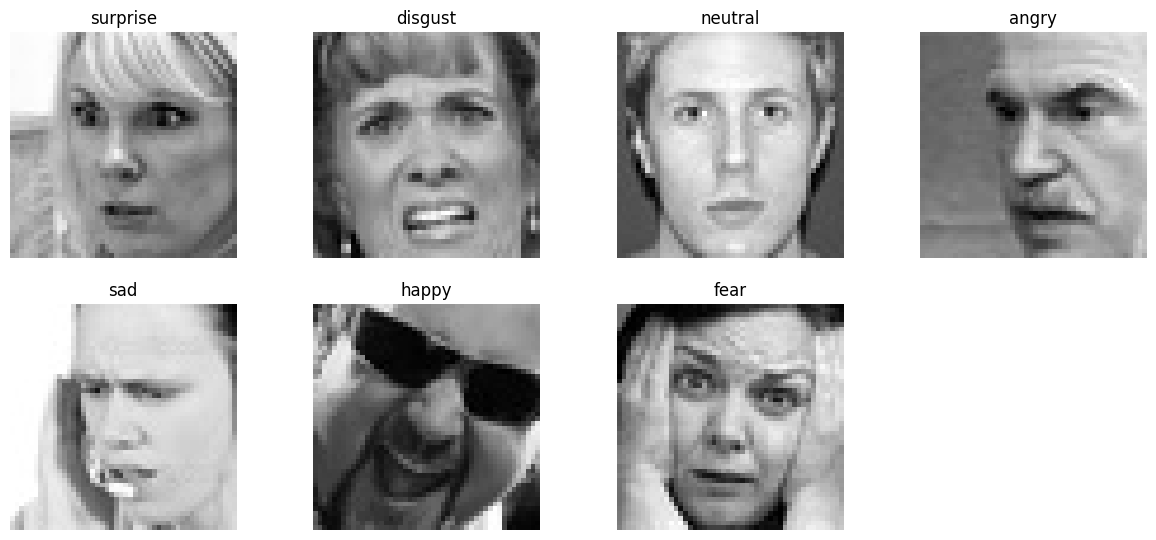

In [10]:
emotions = os.listdir(train_dir)
plt.figure(figsize=(15,10))

for i, emotion in enumerate(emotions,1):
  folder = os.path.join(train_dir,emotion)
  img_path = os.path.join(folder,os.listdir(folder)[42])
  img = plt.imread(img_path)
  plt.subplot(3,4,i)
  plt.imshow(img,cmap='gray')
  plt.title(emotion)
  plt.axis('off')

In [11]:
#plot random images

def plot_images_from_directory(directory_path,class_name,num_images=9):
  image_filenames = os.listdir(directory_path)

  if len(image_filenames) < num_images:
    print(f"Only found {len(image_filenames)} images in {directory_path}, displaying them all.")
    num_images = len(image_filenames)

  selected_images = random.sample(image_filenames,num_images)

  fig,axes = plt.subplots(3,3,figsize=(5,5))  #adjust size as needed
  axes = axes.ravel()

  for i ,image_file in enumerate(selected_images):
    image_path = os.path.join(directory_path,image_file)
    image = load_img(image_path)
    axes[i].imshow(image)
    axes[i].set_title(f"Image: {class_name}")
    axes[i].axis('off')   #hide the axis

  plt.tight_layout()
  plt.show()

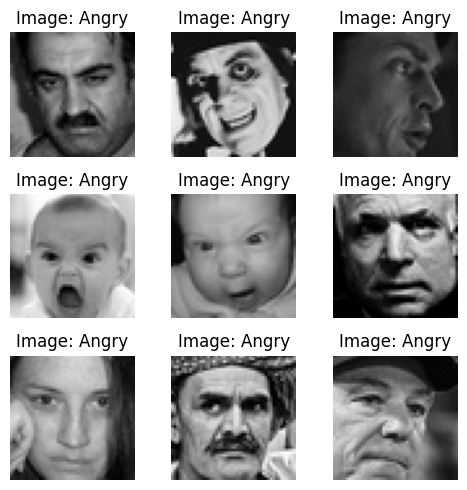

In [12]:
angry_directory_path = '/content/train/angry'
plot_images_from_directory(angry_directory_path,class_name = 'Angry')

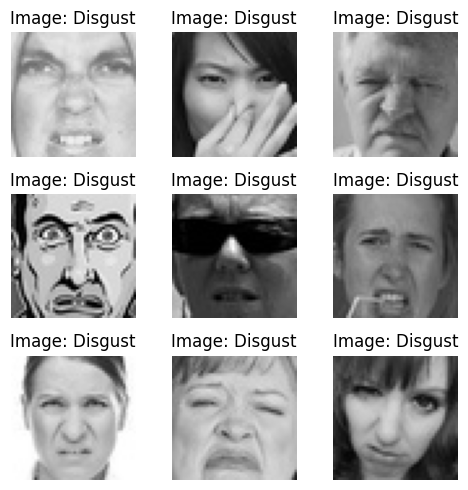

In [13]:
disgust_directory_path = '/content/train/disgust'
plot_images_from_directory(disgust_directory_path,class_name = 'Disgust')

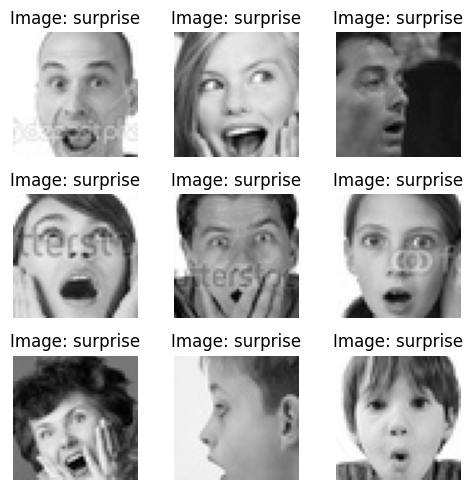

In [14]:
surprise_directory_path = '/content/train/surprise'
plot_images_from_directory(surprise_directory_path,class_name = 'surprise')

In [15]:
image = '/content/train/angry/Training_10118481.jpg'

import cv2
img = cv2.imread(image)
if img is not None:
  print("Shape:",img.shape)

else:
  print("The iamge could not be loaded. Please check the path and file permission.")

Shape: (48, 48, 3)


In [16]:
image_path = '/content/train/angry/Training_10118481.jpg'

import cv2
img = cv2.imread(image_path,cv2.IMREAD_GRAYSCALE)

if img is not None:
  print("Shape:",img.shape)

else:
  print("The iamge could not be loaded. Please check the path and file permission.")

Shape: (48, 48)


Custom CNN Model

In [17]:
train_data_dir = '/content/train'
test_data_dir = '/content/test'

In [18]:
img_width,img_height = 48,48
batch_size = 64
epochs = 10
num_classes = 7  #update this based on the no. of classes

In [19]:
data_generator = ImageDataGenerator(rescale = 1./255,
                                    validation_split = 0.2)

train_generator = data_generator.flow_from_directory(
    train_data_dir,
    target_size=(img_width,img_height),
    batch_size=batch_size,
    class_mode = 'categorical',
    color_mode = 'grayscale',
    subset='training')

validation_generator = data_generator.flow_from_directory(
    train_data_dir,
    target_size=(img_width,img_height),
    batch_size=batch_size,
    class_mode = 'categorical',
    color_mode = 'grayscale',
    subset='validation')

test_generator = data_generator.flow_from_directory(
    test_data_dir,
    target_size=(img_width,img_height),
    batch_size=batch_size,
    class_mode = 'categorical',
    color_mode = 'grayscale',
    # subset='validation'
    )

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [20]:
#access data for train validation and test data
train_class_labels = train_generator.class_indices
print("Training class labels:" , train_class_labels)

validation_class_labels = validation_generator.class_indices
print("Validation class labels:" , validation_class_labels)

test_class_labels = test_generator.class_indices
print("Testing class labels:" , test_class_labels)

Training class labels: {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}
Validation class labels: {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}
Testing class labels: {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}


In [21]:
#initialising the CNN
model = Sequential()

model.add(Conv2D(32,kernel_size=(3,3),kernel_initializer="glorot_uniform",padding='same',input_shape=(img_width,img_height,1)))
model.add(Activation('relu'))
model.add(Conv2D(64,kernel_size=(3,3),padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(128,kernel_size=(3,3),padding='same',kernel_regularizer = regularizers.l2(0.01)))
model.add(Activation('relu'))
model.add(Conv2D(256,kernel_size=(3,3),kernel_regularizer = regularizers.l2(0.01)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(512,kernel_size=(3,3),padding='same',kernel_regularizer = regularizers.l2(0.01)))
model.add(Activation('relu'))
model.add(Conv2D(512,kernel_size=(3,3),padding='same',kernel_regularizer = regularizers.l2(0.01)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(1024))
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(num_classes))
model.add(Activation('softmax'))

In [22]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        320       
                                                                 
 activation (Activation)     (None, 48, 48, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        18496     
                                                                 
 activation_1 (Activation)   (None, 48, 48, 64)        0         
                                                                 
 batch_normalization (Batch  (None, 48, 48, 64)        256       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 24, 24, 64)        0         
 D)                                                     

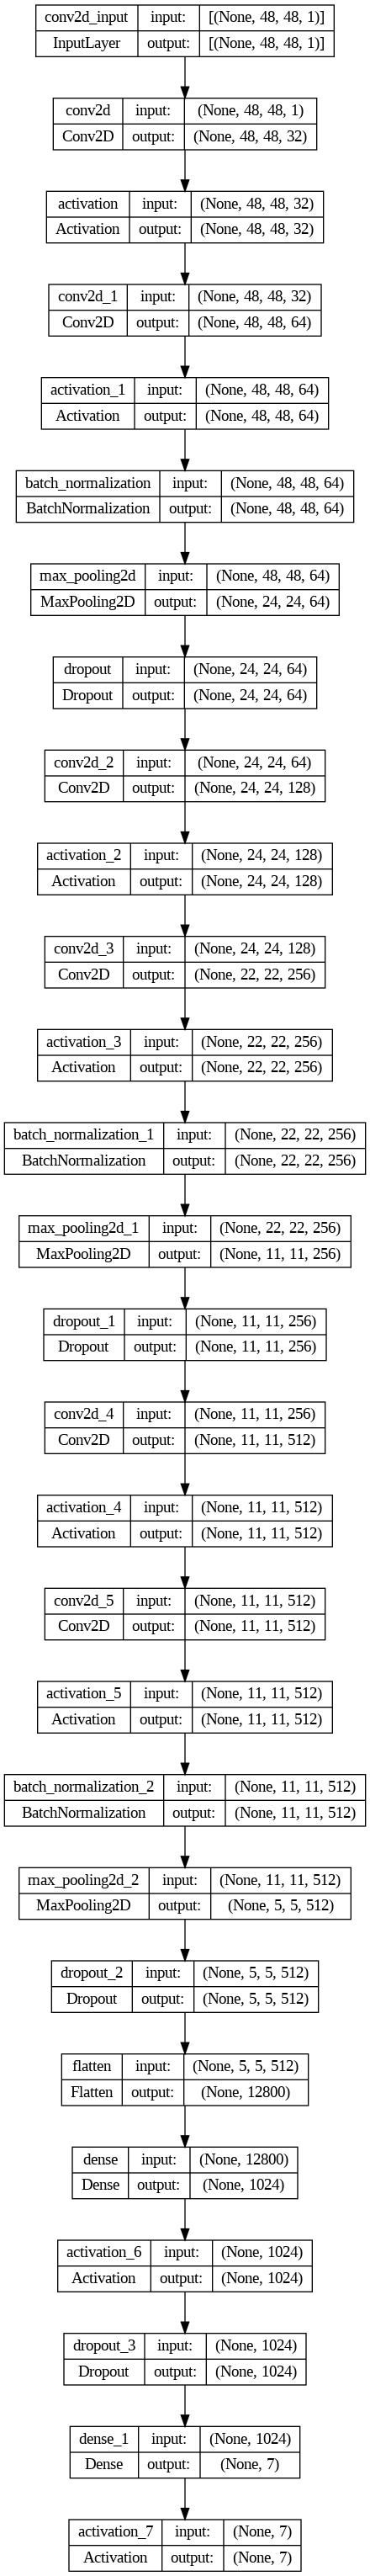

In [24]:
plot_model(model,to_file = '/content/Emotion Detection/CNN/Architecture.png',show_shapes=True,show_layer_names=True)

 callbacks


In [25]:
cnn_path = '/content/Emotion Detection/CNN'
name = 'Custom_CNN_model.keras'
chk_path = os.path.join(cnn_path,name)
chk_path

'/content/Emotion Detection/CNN/Custom_CNN_model.keras'

In [26]:
#callback to save model checkpoint
checkpoint = ModelCheckpoint(filepath = chk_path,
                             save_best_only=True,
                             verbose=1,
                             mode='min',
                             monitor='val_loss')

In [27]:
#callback for early stopping
earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=3,
                          verbose=1,
                          restore_best_weights=True)

In [28]:
#callback for reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=6,
                              verbose=1,
                              min_delta=0.0001)

In [29]:
#callback to log training data to csv file
csv_logger = CSVLogger(os.path.join(cnn_path,'training.log'))

In [30]:
#aggregate all callbacks into list
callbacks = [checkpoint,earlystop,reduce_lr,csv_logger]

In [31]:
train_generator.samples

22968

In [32]:
train_steps_per_epoch = train_generator.samples // train_generator.batch_size + 1
validation_steps_epoch = validation_generator.samples // validation_generator.batch_size + 1
test_steps_epoch = test_generator.samples // test_generator.batch_size + 1

model training


In [33]:
history = model.fit(
    train_generator,
    steps_per_epoch = train_steps_per_epoch,
    epochs= 10,
    validation_data = validation_generator,
    validation_steps = validation_steps_epoch,
    callbacks = callbacks)

Epoch 1/10
359/359 [==============================] - ETA: 0s - loss: 12.2272 - accuracy: 0.3009
Epoch 1: val_loss improved from inf to 15.35930, saving model to /content/Emotion Detection/CNN/Custom_CNN_model.keras
359/359 [==============================] - 40s 82ms/step - loss: 12.2272 - accuracy: 0.3009 - val_loss: 15.3593 - val_accuracy: 0.0214 - lr: 1.0000e-04
Epoch 2/10
359/359 [==============================] - ETA: 0s - loss: 9.8099 - accuracy: 0.3912
Epoch 2: val_loss improved from 15.35930 to 9.19468, saving model to /content/Emotion Detection/CNN/Custom_CNN_model.keras
359/359 [==============================] - 27s 74ms/step - loss: 9.8099 - accuracy: 0.3912 - val_loss: 9.1947 - val_accuracy: 0.4006 - lr: 1.0000e-04
Epoch 3/10
359/359 [==============================] - ETA: 0s - loss: 7.6914 - accuracy: 0.4431
Epoch 3: val_loss improved from 9.19468 to 6.91179, saving model to /content/Emotion Detection/CNN/Custom_CNN_model.keras
359/359 [==============================] - 26

In [34]:
#plot performance
def plot_training_history(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs_range = range(len(acc))

  plt.figure(figsize=(20,5))

  plt.subplot(1,2,1)
  plt.plot(epochs_range,acc,label='Training Accuracy')
  plt.plot(epochs_range,val_acc,label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  plt.subplot(1,2,2)
  plt.plot(epochs_range,loss,label='Training Loss')
  plt.plot(epochs_range,val_loss,label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')

  plt.show()

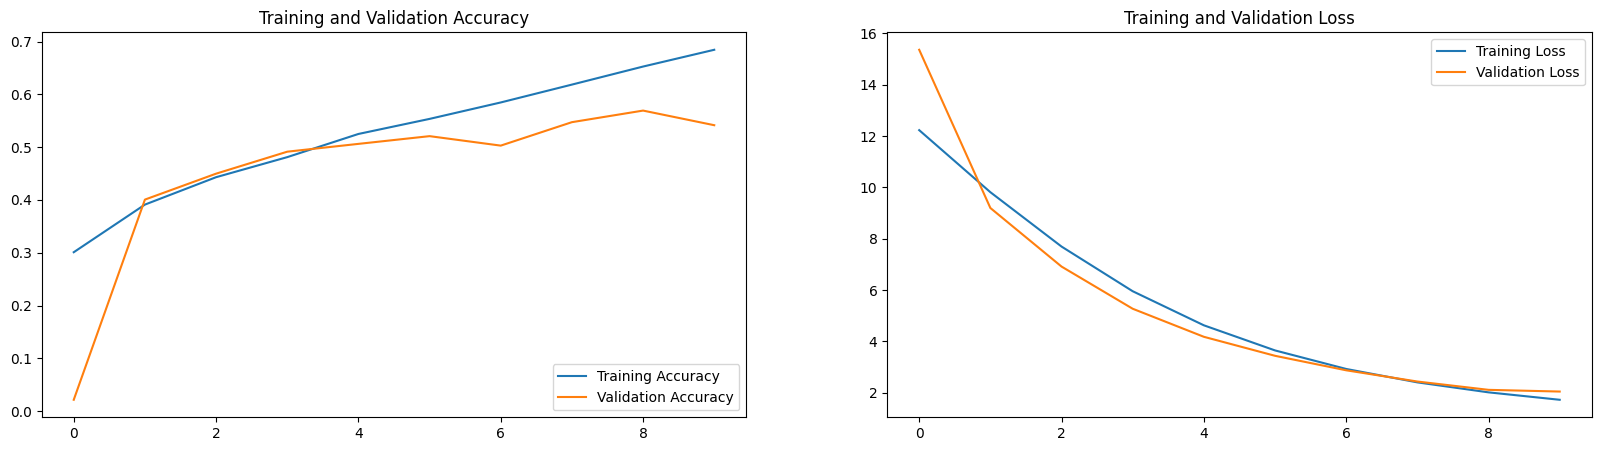

In [35]:
plot_training_history(history)

In [36]:
#model evaluation
train_loss,train_accu = model.evaluate(train_generator)
test_loss,test_accu = model.evaluate(test_generator)
print("final train accuracy= {:.2f} , validation accuracy = {:.2f}".format(train_accu*100, test_accu*100))

113/113 [==============================] - 3s 29ms/step - loss: 2.0287 - accuracy: 0.5435
final train accuracy= 69.95 , validation accuracy = 54.35


113/113 [==============================] - 3s 23ms/step


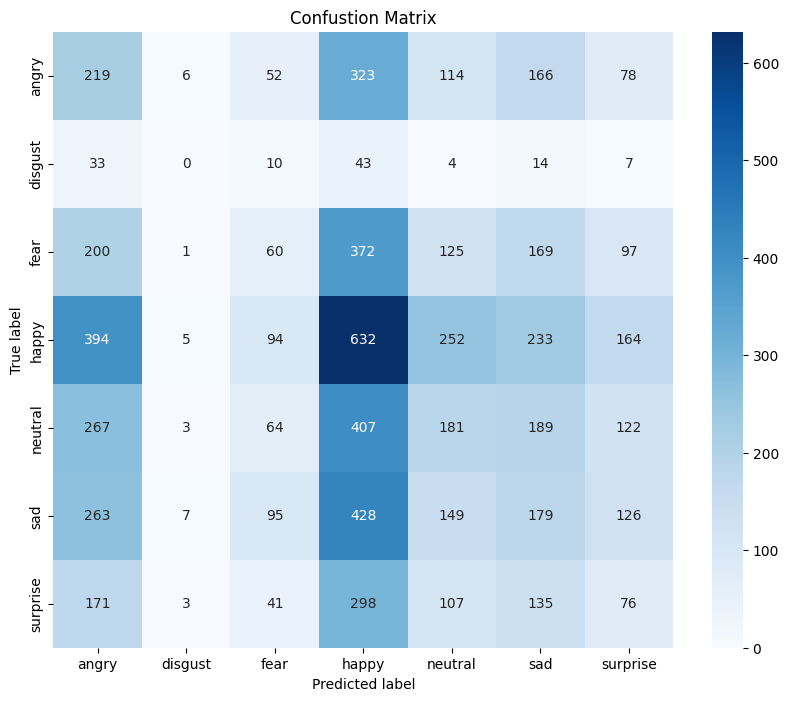

In [37]:
#confusion matrix
true_classes = test_generator.classes
predicted_classes = np.argmax(model.predict(test_generator,steps=np.ceil(test_generator.samples/test_generator.batch_size)),axis=1)
class_labels = list(test_generator.class_indices.keys())

cm = confusion_matrix(true_classes,predicted_classes)

plt.figure(figsize=(10,8))
sns.heatmap(cm,annot=True,fmt="d",cmap="Blues",xticklabels=class_labels,yticklabels=class_labels)
plt.title('Confustion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [38]:
#classification report
report = classification_report(true_classes,predicted_classes,target_names=class_labels)
print("Classification Report:\n",report)

Classification Report:
               precision    recall  f1-score   support

       angry       0.14      0.23      0.17       958
     disgust       0.00      0.00      0.00       111
        fear       0.14      0.06      0.08      1024
       happy       0.25      0.36      0.30      1774
     neutral       0.19      0.15      0.17      1233
         sad       0.16      0.14      0.15      1247
    surprise       0.11      0.09      0.10       831

    accuracy                           0.19      7178
   macro avg       0.14      0.15      0.14      7178
weighted avg       0.18      0.19      0.18      7178



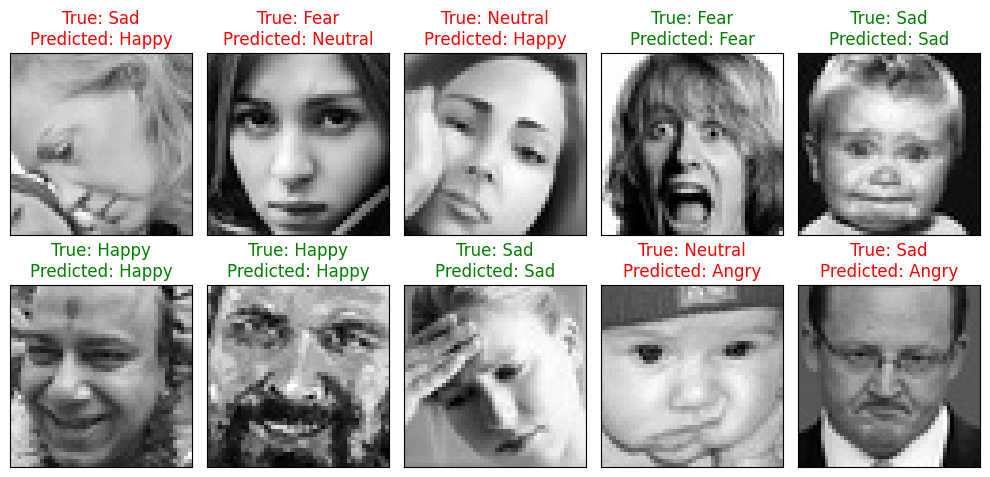

In [39]:

# Emotion classes for the dataset
Emotion_Classes = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']

# Assuming test_generator and model are already defined
batch_size = test_generator.batch_size

# Selecting a random batch from the test generator
Random_batch = np.random.randint(0, len(test_generator) - 1)

# Selecting random image indices from the batch
Random_Img_Index = np.random.randint(0, batch_size, 10)

# Setting up the plot
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10, 5),
                         subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    # Fetching the random image and its label
    Random_Img = test_generator[Random_batch][0][Random_Img_Index[i]]
    Random_Img_Label = np.argmax(test_generator[Random_batch][1][Random_Img_Index[i]], axis=0)

    # Making a prediction using the model
    Model_Prediction = np.argmax(model.predict(tf.expand_dims(Random_Img, axis=0), verbose=0), axis=1)[0]

    # Displaying the image
    ax.imshow(Random_Img.squeeze(), cmap='gray')  # Assuming the images are grayscale
    # Setting the title with true and predicted labels, colored based on correctness
    color = "green" if Emotion_Classes[Random_Img_Label] == Emotion_Classes[Model_Prediction] else "red"
    ax.set_title(f"True: {Emotion_Classes[Random_Img_Label]}\nPredicted: {Emotion_Classes[Model_Prediction]}", color=color)

plt.tight_layout()
plt.show()

Image Augmentation

In [40]:

# Define paths to the train and validation directories
train_data_dir = '/content/train'
test_data_dir = '/content/test'
# validation_data_dir = '/content/emotion_detection_project/datasets/raw/test'

# Set some parameters
img_width, img_height = 48, 48  # Size of images
batch_size = 64
epochs = 10
num_classes = 7  # Update this based on the number of your classes


# Initializing the ImageDataGenerator with data augmentation options for the training set
data_generator = ImageDataGenerator(
    rescale=1./255,  # Rescale the pixel values from [0, 255] to [0, 1]
    rotation_range=40,  # Degree range for random rotations
    width_shift_range=0.2,  # Range (as a fraction of total width) for random horizontal shifts
    height_shift_range=0.2,  # Range (as a fraction of total height) for random vertical shifts
    shear_range=0.2,  # Shearing intensity (shear angle in counter-clockwise direction)
    zoom_range=0.2,  # Range for random zoom
    horizontal_flip=True,  # Randomly flip inputs horizontally
    fill_mode='nearest',  # Strategy to fill newly created pixels, which can appear after a rotation or a width/height shift
    validation_split=0.2  # Set the validation split; 20% of the data will be used for validation
)

test_data_generator = ImageDataGenerator(rescale=1./255)


# Automatically retrieve images and their classes for train and validation sets
train_generator = data_generator.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale',
    subset='training')

validation_generator = data_generator.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale',
    subset='validation')

test_generator = test_data_generator.flow_from_directory(
    test_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale'
    )

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


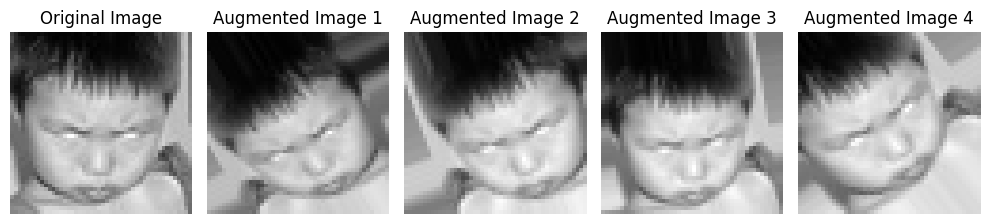

In [41]:

# Path to your specific image
image_path = '/content/train/angry/Training_10118481.jpg'

# Load and convert the image to an array
img = load_img(image_path, color_mode='grayscale', target_size=(img_width, img_height))  # Adjust color_mode if necessary
img_array = img_to_array(img)  # Converts the image to a numpy array
img_array = img_array.reshape((1,) + img_array.shape)  # Reshapes the image to (1, width, height, channels) for the generator

# Setting up the plot
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(10, 4))
# Plot the original image first. Since img_array is a 3D array after reshaping, we use [:, :, 0]
axes[0].imshow(img_array[0, :, :, 0], cmap='gray')
axes[0].set_title('Original Image')
axes[0].axis('off')

# Generate and plot augmented images
for i, ax in enumerate(axes.flat[1:]):  # Start from the second subplot
    # Generate a batch of augmented images
    aug_iter = data_generator.flow(img_array, batch_size=1)
    aug_img = next(aug_iter)[0]  # Get the first augmented image from the batch

    # Plot the augmented image. We directly use [:, :, 0] without an initial batch index
    ax.imshow(aug_img[:, :, 0], cmap='gray')
    ax.set_title(f'Augmented Image {i+1}')
    ax.axis('off')

plt.tight_layout()
plt.show()

Same CNN Model as above

In [42]:


# Assuming img_width, img_height, and classes are defined. For example:
img_width, img_height = 48, 48
classes = 7

#Initialising the CNN
model = tf.keras.models.Sequential()

# Adding convolutional layers with activations on separate lines
model.add(Conv2D(32, kernel_size=(3, 3), padding='same', input_shape=(img_width, img_height, 1)))
model.add(tf.keras.layers.Activation('relu'))
model.add(Conv2D(64, kernel_size=(3, 3), padding='same'))
model.add(tf.keras.layers.Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2, 2))
model.add(Dropout(0.25))

model.add(Conv2D(128, kernel_size=(3, 3), padding='same', kernel_regularizer=regularizers.l2(0.01)))
model.add(tf.keras.layers.Activation('relu'))
model.add(Conv2D(256, kernel_size=(3, 3), kernel_regularizer=regularizers.l2(0.01)))
model.add(tf.keras.layers.Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(512, kernel_size=(3, 3), padding='same', kernel_regularizer=regularizers.l2(0.01)))
model.add(tf.keras.layers.Activation('relu'))
model.add(Conv2D(512, kernel_size=(3, 3), padding='same', kernel_regularizer=regularizers.l2(0.01)))
model.add(tf.keras.layers.Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Flattening and adding dense layers
model.add(Flatten())
model.add(Dense(1024))
model.add(tf.keras.layers.Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(classes))
model.add(tf.keras.layers.Activation('softmax'))

# Compiling the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


# File path for the model checkpoint
cnn_path = '/content/Emotion Detection/CNN_with_Augmentation'
name = 'Custom_CNN_augmented_model.keras'
chk_path = os.path.join(cnn_path, name)

# Callback to save the model checkpoint
checkpoint = ModelCheckpoint(filepath=chk_path,
                             save_best_only=True,
                             verbose=1,
                             mode='min',
                             monitor='val_loss')

# Callback for early stopping
earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=3,
                          verbose=1,
                          restore_best_weights=True)

# Callback to reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=6,
                              verbose=1,
                              min_delta=0.0001)

# Callback to log training data to a CSV file
csv_logger = CSVLogger(os.path.join(cnn_path,'training.log'))

# Aggregating all callbacks into a list
callbacks = [checkpoint, earlystop, reduce_lr, csv_logger]  # Adjusted as per your use-case

train_steps_per_epoch = train_generator.samples // train_generator.batch_size + 1
validation_steps_epoch = validation_generator.samples // validation_generator.batch_size + 1
test_steps_epoch = test_generator.samples // test_generator.batch_size + 1

history = model.fit(
    train_generator,
    steps_per_epoch=train_steps_per_epoch,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=validation_steps_epoch,
    callbacks=callbacks)

Epoch 1/10
359/359 [==============================] - ETA: 0s - loss: 12.4798 - accuracy: 0.2197
Epoch 1: val_loss improved from inf to 13.03052, saving model to /content/Emotion Detection/CNN_with_Augmentation/Custom_CNN_augmented_model.keras
359/359 [==============================] - 36s 92ms/step - loss: 12.4798 - accuracy: 0.2197 - val_loss: 13.0305 - val_accuracy: 0.1730 - lr: 1.0000e-04
Epoch 2/10
359/359 [==============================] - ETA: 0s - loss: 10.2603 - accuracy: 0.2429
Epoch 2: val_loss improved from 13.03052 to 10.00407, saving model to /content/Emotion Detection/CNN_with_Augmentation/Custom_CNN_augmented_model.keras
359/359 [==============================] - 34s 94ms/step - loss: 10.2603 - accuracy: 0.2429 - val_loss: 10.0041 - val_accuracy: 0.2275 - lr: 1.0000e-04
Epoch 3/10
359/359 [==============================] - ETA: 0s - loss: 8.1333 - accuracy: 0.2507
Epoch 3: val_loss improved from 10.00407 to 7.30712, saving model to /content/Emotion Detection/CNN_with_Au

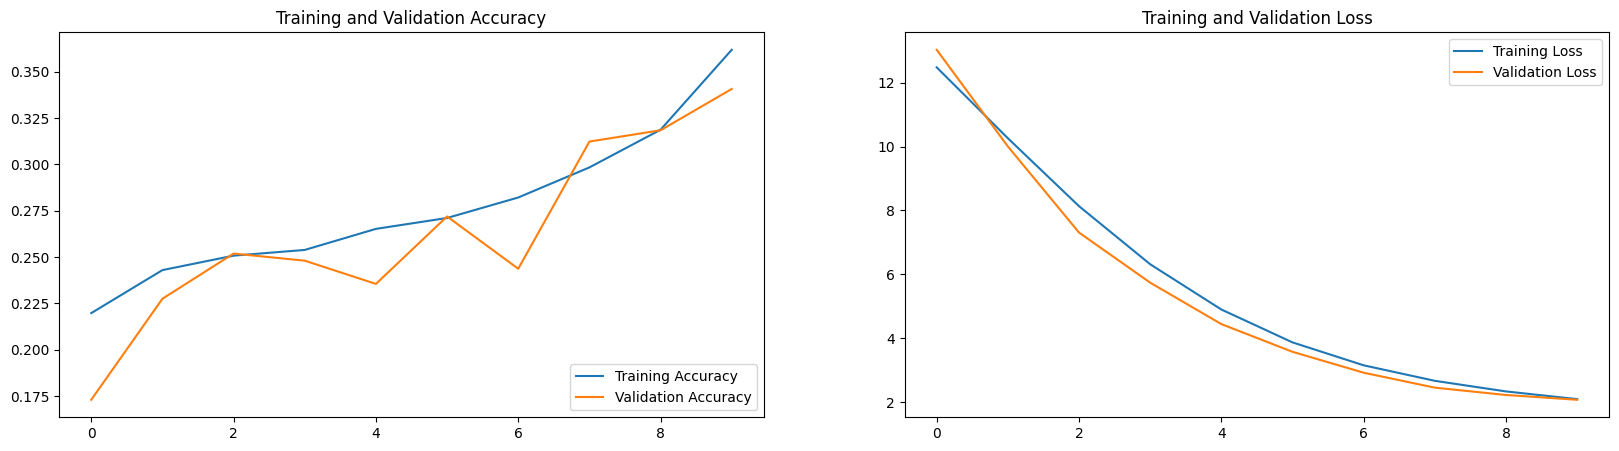

In [43]:
plot_training_history(history)

In [44]:
train_loss, train_accu = model.evaluate(train_generator)
test_loss, test_accu = model.evaluate(test_generator)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_accu*100, test_accu*100))

113/113 [==============================] - 3s 25ms/step - loss: 1.8951 - accuracy: 0.4256
final train accuracy = 34.63 , validation accuracy = 42.56


113/113 [==============================] - 3s 23ms/step


Text(0.5, 58.7222222222222, 'Predicted label')

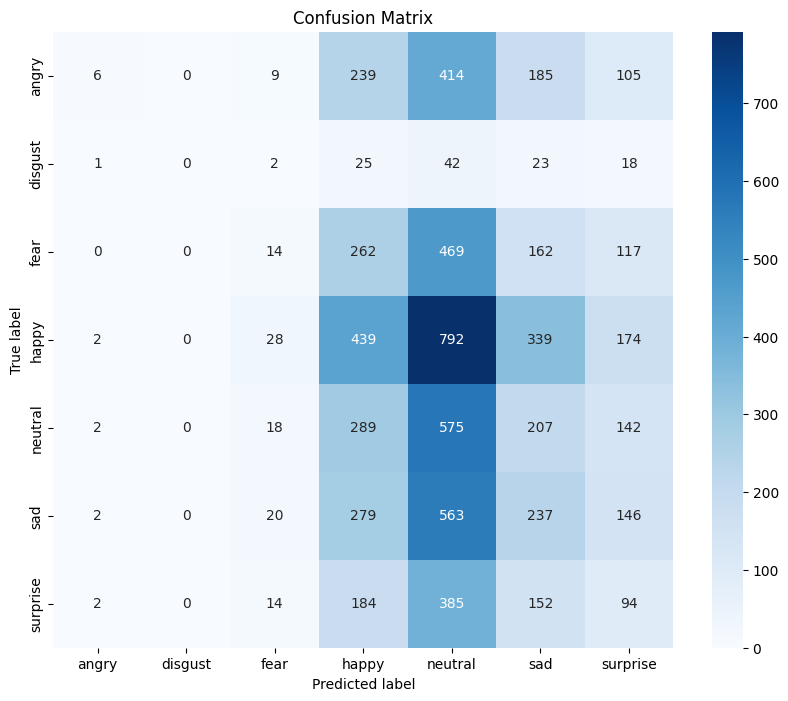

In [45]:
# Assuming your true_classes and predicted_classes are already defined
true_classes = test_generator.classes
predicted_classes = np.argmax(model.predict(test_generator, steps=np.ceil(test_generator.samples/test_generator.batch_size)), axis=1)
class_labels = list(test_generator.class_indices.keys())

# Generate the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plotting with seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [46]:
# Printing the classification report
report = classification_report(true_classes,
                               predicted_classes,
                               target_names=class_labels,
                               zero_division=0)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

       angry       0.40      0.01      0.01       958
     disgust       0.00      0.00      0.00       111
        fear       0.13      0.01      0.02      1024
       happy       0.26      0.25      0.25      1774
     neutral       0.18      0.47      0.26      1233
         sad       0.18      0.19      0.19      1247
    surprise       0.12      0.11      0.12       831

    accuracy                           0.19      7178
   macro avg       0.18      0.15      0.12      7178
weighted avg       0.21      0.19      0.16      7178



Transfer Learning VGGNET

In [47]:

# Define paths to the train and validation directories
train_data_dir = '/content/train'
test_data_dir = '/content/test'

# validation_data_dir = '/content/emotion_detection_project/datasets/raw/test'

# Set some parameters
img_width, img_height = 224, 224  # Size of images
batch_size = 64
epochs = 10
num_classes = 7  # Update this based on the number of your classes

# Rescale the pixel values (0-255) to the [0, 1] interval
data_generator = ImageDataGenerator(
                                rescale = 1 / 255.,
                                rotation_range=10,
                                zoom_range=0.2,
                                width_shift_range=0.1,
                                height_shift_range=0.1,
                                horizontal_flip=True,
                                fill_mode='nearest',
                                # validation_split=0.2
                                )

test_preprocessor = ImageDataGenerator(
    rescale = 1 / 255.,
)

# Automatically retrieve images and their classes for train and validation sets
train_generator = data_generator.flow_from_directory(
                                train_data_dir,
                                target_size=(img_width, img_height),
                                batch_size=batch_size,
                                class_mode='categorical',
                                color_mode='rgb',
                                subset='training',
                                shuffle = True)

test_generator = test_preprocessor.flow_from_directory(
                                test_data_dir,
                                target_size=(img_width, img_height),
                                batch_size=batch_size,
                                class_mode='categorical',
                                color_mode='rgb',)
                                # subset='validation')

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [48]:
classes = 7

# Clear the previous TensorFlow sessionx
tf.keras.backend.clear_session()

# Load the VGG16 base model, excluding its top (fully connected) layers
vgg = VGG16(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
vgg.summary()

58889256/58889256 [==============================] - 4s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

In [49]:
# Make the specified layers non-trainable
for layer in vgg.layers[:-3]:
    layer.trainable = False

vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [50]:

# Flattening the layer and adding custom Dense layers
x = Flatten()(vgg.output)

# Adding a fully connected layer with ReLU activation and He normal initializer
x = Dense(1024, activation='relu', kernel_initializer='he_normal')(x)
x = Dropout(0.5)(x)  # Adding dropout for regularization

x = Dense(512, activation='relu', kernel_initializer='he_normal')(x)
x = Dropout(0.5)(x)  # Adding dropout for regularization

# Adding the output layer with softmax activation
# Note: Adjust the number of units to match the number of classes you have
output = Dense(classes, activation='softmax', kernel_initializer='he_normal')(x)

# Creating the model
model = Model(inputs=vgg.input, outputs=output)

# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, amsgrad=False),
              metrics=['accuracy'])

# Model summary to see all layers
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [54]:

# File path for the model checkpoint
cnn_path = '/content/Emotion Detection/VGG16_transfer_learning'
name = 'VGG16_Transfer_Learning.keras'
chk_path = os.path.join(cnn_path, name)

# Callback to save the model checkpoint
checkpoint =ModelCheckpoint(filepath=chk_path,
                             save_best_only=True,
                             verbose=1,
                             mode='min',
                             monitor='val_loss')

# Callback for early stopping
earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=3,
                          verbose=1,
                          restore_best_weights=True)

# Callback to reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=6,
                              verbose=1,
                              min_delta=0.0001)

# Callback to log training data to a CSV file
csv_logger = CSVLogger(os.path.join(cnn_path,'training.log'))

# Aggregating all callbacks into a list
callbacks = [checkpoint, earlystop, reduce_lr, csv_logger]  # Adjusted as per your use-case

train_steps_per_epoch = train_generator.samples // train_generator.batch_size + 1
# validation_steps_epoch = validation_generator.samples // validation_generator.batch_size + 1
test_steps_epoch = test_generator.samples // test_generator.batch_size + 1

In [52]:
history = model.fit(train_generator,
                    steps_per_epoch=train_steps_per_epoch,
                    validation_data=test_generator,
                    validation_steps=test_steps_epoch,
                    epochs=5,
                    callbacks = callbacks)

Epoch 1/5
449/449 [==============================] - ETA: 0s - loss: 1.5843 - accuracy: 0.3820
Epoch 1: val_loss improved from inf to 1.33902, saving model to /content/Emotion Detection/VGG16_transfer_learning/VGG16_Transfer_Learning.keras
449/449 [==============================] - 509s 1s/step - loss: 1.5843 - accuracy: 0.3820 - val_loss: 1.3390 - val_accuracy: 0.4978 - lr: 1.0000e-04
Epoch 2/5
449/449 [==============================] - ETA: 0s - loss: 1.3590 - accuracy: 0.4783
Epoch 2: val_loss improved from 1.33902 to 1.24920, saving model to /content/Emotion Detection/VGG16_transfer_learning/VGG16_Transfer_Learning.keras
449/449 [==============================] - 469s 1s/step - loss: 1.3590 - accuracy: 0.4783 - val_loss: 1.2492 - val_accuracy: 0.5249 - lr: 1.0000e-04
Epoch 3/5
449/449 [==============================] - ETA: 0s - loss: 1.2752 - accuracy: 0.5161
Epoch 3: val_loss improved from 1.24920 to 1.20383, saving model to /content/Emotion Detection/VGG16_transfer_learning/VGG1

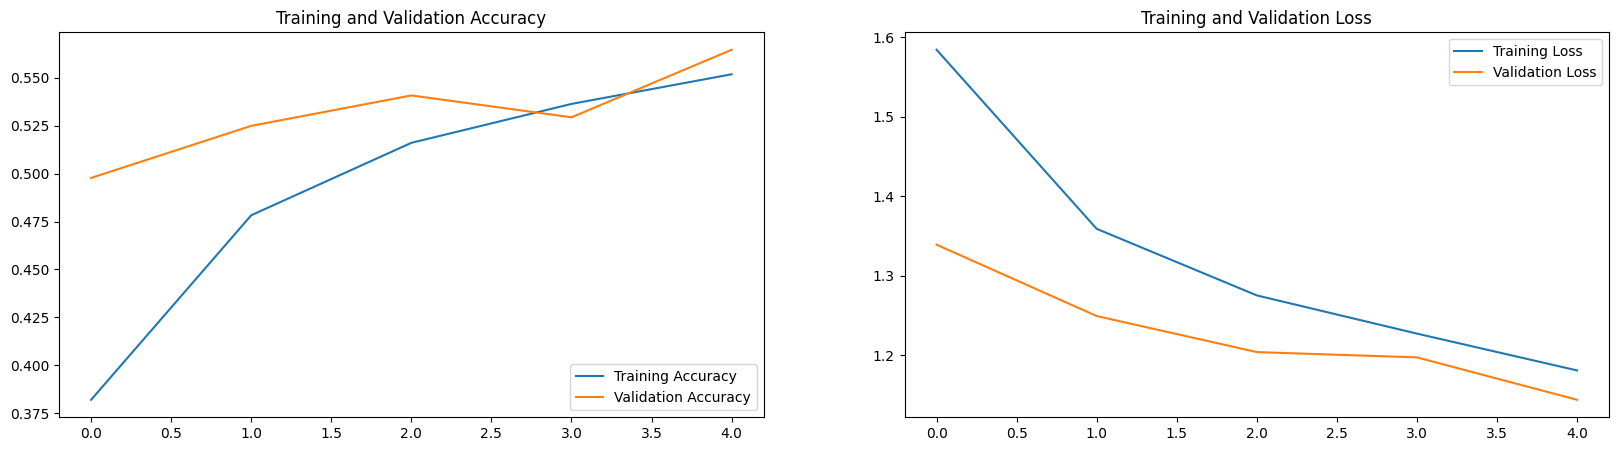

In [56]:
plot_training_history(history)

In [57]:
train_loss, train_accu = model.evaluate(train_generator)
test_loss, test_accu = model.evaluate(test_generator)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_accu*100, test_accu*100))

113/113 [==============================] - 30s 262ms/step - loss: 1.1438 - accuracy: 0.5646
final train accuracy = 58.75 , validation accuracy = 56.46


113/113 [==============================] - 30s 264ms/step


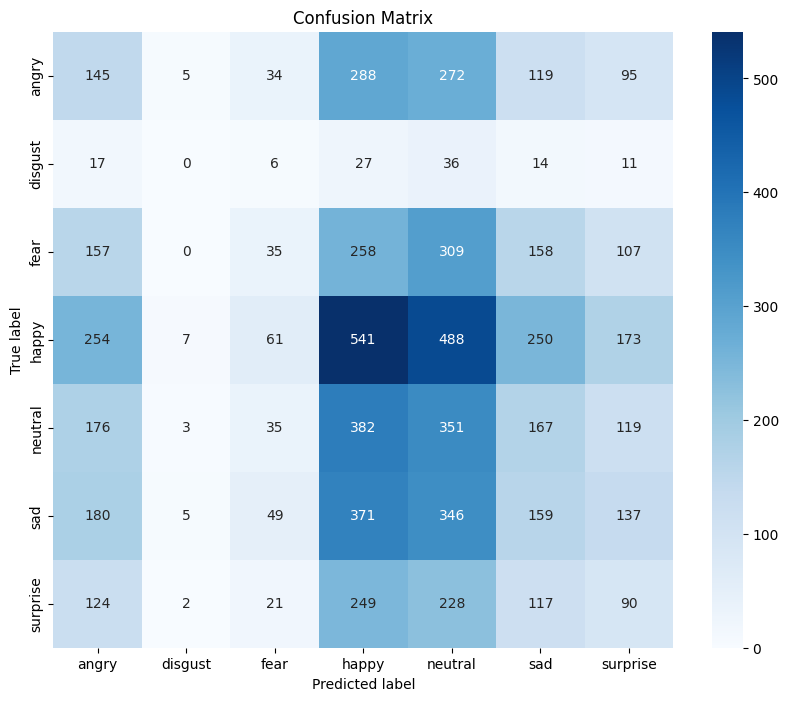

In [58]:
# Assuming your true_classes and predicted_classes are already defined
true_classes = test_generator.classes
predicted_classes = np.argmax(model.predict(test_generator, steps=np.ceil(test_generator.samples/test_generator.batch_size)), axis=1)
class_labels = list(test_generator.class_indices.keys())

# Generate the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plotting with seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [59]:
# Printing the classification report
report = classification_report(true_classes,
                               predicted_classes,
                               target_names=class_labels,
                               zero_division=0)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

       angry       0.14      0.15      0.14       958
     disgust       0.00      0.00      0.00       111
        fear       0.15      0.03      0.06      1024
       happy       0.26      0.30      0.28      1774
     neutral       0.17      0.28      0.22      1233
         sad       0.16      0.13      0.14      1247
    surprise       0.12      0.11      0.12       831

    accuracy                           0.18      7178
   macro avg       0.14      0.14      0.14      7178
weighted avg       0.17      0.18      0.17      7178



Transfer Learning ResNet50

In [60]:

train_dir = '/content/train'
test_dir = '/content/test'

# Data augmentation configuration for training data
train_datagen = ImageDataGenerator(rescale=1/255,                # Rescale pixel values to [0, 1]
                                  rotation_range=40,            # Randomly rotate images in the range (degrees, 0 to 180)
                                  width_shift_range=0.2,        # Randomly horizontally shift images
                                  height_shift_range=0.2,       # Randomly vertically shift images
                                  shear_range=0.2,              # Apply shearing transformations
                                  zoom_range=0.1,               # Randomly zoom image
                                  horizontal_flip=True,         # Randomly flip images horizontally
                                  fill_mode='nearest'           # Strategy used for filling in newly created pixels
                                )

# Rescaling for validation/test data (without further data augmentation)
test_datagen = ImageDataGenerator(
                                  rescale=1/255                 # Rescale pixel values to [0, 1]
                              )

# Creating data generators for training
train_generator = train_datagen.flow_from_directory(
                                                    train_dir,
                                                    target_size=(224, 224),       # Resize images to 224x224 for model input
                                                    color_mode='rgb',             # Images will be converted to RGB
                                                    class_mode='categorical',     # For multi-class classification
                                                    batch_size=32                 # Size of the batches of data
                                                )

# Creating data generators for testing/validation
test_generator = test_datagen.flow_from_directory(
                                                  test_dir,
                                                  target_size=(224, 224),       # Resize images to 224x224 for model input
                                                  color_mode='rgb',             # Images will be converted to RGB
                                                  class_mode='categorical',     # For multi-class classification
                                                  batch_size=32                 # Size of the batches of data
                                              )

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


Introduce class weight for imbalance data

In [61]:
# Extract class labels for all instances in the training dataset
classes = np.array(train_generator.classes)

# Calculate class weights to handle imbalances in the training data
# 'balanced' mode automatically adjusts weights inversely proportional to class frequencies
class_weights = compute_class_weight(
    class_weight='balanced',  # Strategy to balance classes
    classes=np.unique(classes),  # Unique class labels
    y=classes  # Class labels for each instance in the training dataset
)

# Create a dictionary mapping class indices to their calculated weights
class_weights_dict = dict(enumerate(class_weights))

# Output the class weights dictionary
print("Class Weights Dictionary:", class_weights_dict)

Class Weights Dictionary: {0: 1.0266046844269623, 1: 9.406618610747051, 2: 1.0010460615781582, 3: 0.5684387684387684, 4: 0.8260394187886635, 5: 0.8491274770777877, 6: 1.293372978330405}


In [62]:
ResNet50V2 = tf.keras.applications.ResNet50V2(input_shape=(224,224,3),
                                              include_top=False,
                                              weights='imagenet')

94668760/94668760 [==============================] - 5s 0us/step


In [63]:
ResNet50V2.trainable = True
for layer in ResNet50V2.layers[:-50]:
  layer.trainable=False

In [69]:
def Create_ResNet50V2_Model():
  model = Sequential([
                    ResNet50V2,
                    Dropout(0.25),
                    BatchNormalization(),
                    Flatten(),
                    # GlobalAveragePooling2D(),
                    # Dense(512, activation='relu'),
                    # Dropout(0.1),
                    Dense(64, activation='relu'),
                    BatchNormalization(),

                    Dropout(0.5),
                    # Dense(128, activation='relu'),
                    # Dropout(0.1),
                    Dense(7, activation='softmax')
                  ])

  return model

# base_model = ResNet50V2(include_top=False, weights='imagenet', input_shape=input_shape)

# model = Sequential([
#                     # base_model,
#                     BatchNormalization(),
#                     # GlobalAveragePooling2D(),
#                     Dense(512, activation='relu'),
#                     Dropout(0.1),
#                     Dense(256, activation='relu'),
#                     Dropout(0.1),
#                     Dense(128, activation='relu'),
#                     Dropout(0.1),
#                     Dense(7, activation='softmax')
#                   ])

# optimizer = Adamax(learning_rate=0.0001)

# model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
# model.summary()

In [70]:
model = Create_ResNet50V2_Model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 dropout_5 (Dropout)         (None, 7, 7, 2048)        0         
                                                                 
 batch_normalization_2 (Bat  (None, 7, 7, 2048)        8192      
 chNormalization)                                                
                                                                 
 flatten_1 (Flatten)         (None, 100352)            0         
                                                                 
 dense_7 (Dense)             (None, 64)                6422592   
                                                                 
 batch_normalization_3 (Bat  (None, 64)                256       
 chNormalization)                                     

In [71]:
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [72]:
# File path for the model checkpoint
cnn_path = '/content/Emotion Detection/ResNet50_transfer_learning'
name = 'ResNet50_Transfer_Learning.keras'
chk_path = os.path.join(cnn_path, name)

# Callback to save the model checkpoint
checkpoint = ModelCheckpoint(filepath=chk_path,
                             save_best_only=True,
                             verbose=1,
                             mode='min',
                             monitor='val_loss')

# Callback for early stopping
earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=6,
                          verbose=1,
                          restore_best_weights=True)

# Callback to reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=6,
                              verbose=1,
                              min_delta=0.0001)

# Callback to log training data to a CSV file
csv_logger = CSVLogger(os.path.join(cnn_path,'training.log'))

# Aggregating all callbacks into a list
callbacks = [checkpoint, earlystop, csv_logger]  # Adjusted as per your use-case

train_steps_per_epoch = train_generator.samples // train_generator.batch_size + 1
# validation_steps_epoch = validation_generator.samples // validation_generator.batch_size + 1
test_steps_epoch = test_generator.samples // test_generator.batch_size + 1

In [73]:
train_history = model.fit(
                          train_generator,
                          steps_per_epoch=200,
                          epochs=50,
                          validation_data=test_generator,
                          validation_steps=100,
                          class_weight=class_weights_dict,
                          callbacks = callbacks
                        )

Epoch 1/50
200/200 [==============================] - ETA: 0s - loss: 2.8372 - accuracy: 0.1842
Epoch 1: val_loss improved from inf to 2.29968, saving model to /content/Emotion Detection/ResNet50_transfer_learning/ResNet50_Transfer_Learning.keras
200/200 [==============================] - 127s 554ms/step - loss: 2.8372 - accuracy: 0.1842 - val_loss: 2.2997 - val_accuracy: 0.2703
Epoch 2/50
200/200 [==============================] - ETA: 0s - loss: 2.5853 - accuracy: 0.2173
Epoch 2: val_loss improved from 2.29968 to 2.13863, saving model to /content/Emotion Detection/ResNet50_transfer_learning/ResNet50_Transfer_Learning.keras
200/200 [==============================] - 106s 530ms/step - loss: 2.5853 - accuracy: 0.2173 - val_loss: 2.1386 - val_accuracy: 0.2947
Epoch 3/50
200/200 [==============================] - ETA: 0s - loss: 2.4001 - accuracy: 0.2333
Epoch 3: val_loss improved from 2.13863 to 2.06421, saving model to /content/Emotion Detection/ResNet50_transfer_learning/ResNet50_Trans

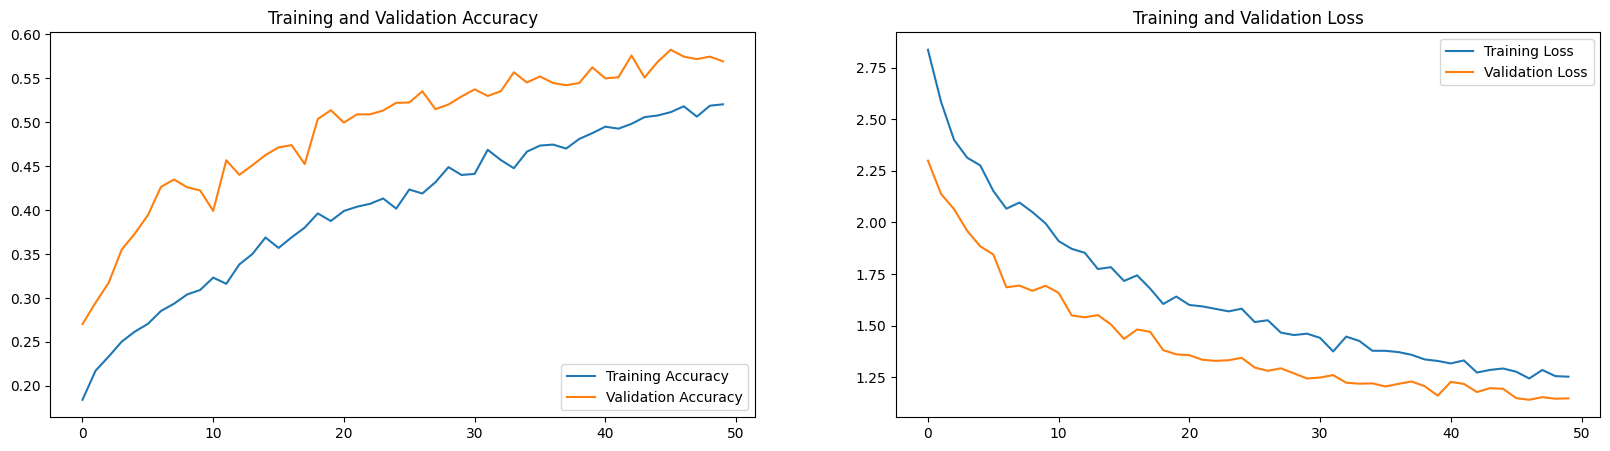

In [74]:
plot_training_history(train_history)

In [75]:
train_loss, train_accu = model.evaluate(train_generator)
test_loss, test_accu = model.evaluate(test_generator)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_accu*100, test_accu*100))

225/225 [==============================] - 23s 100ms/step - loss: 1.1379 - accuracy: 0.5748
final train accuracy = 57.31 , validation accuracy = 57.48


225/225 [==============================] - 21s 89ms/step


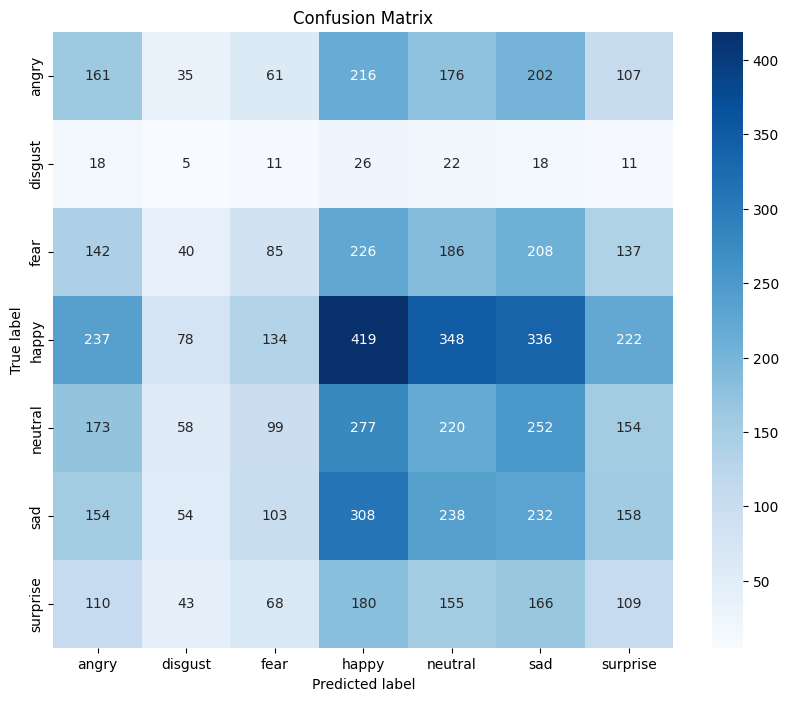

In [77]:
# Assuming your true_classes and predicted_classes are already defined
true_classes = test_generator.classes
predicted_classes = np.argmax(model.predict(test_generator, steps=np.ceil(test_generator.samples/test_generator.batch_size)), axis=1)
class_labels = list(test_generator.class_indices.keys())

# Generate the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plotting with seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [78]:
#auc roc plot for each class
true_labels = test_generator.classes
preds = model.predict(test_generator, steps=len(test_generator))
pred_labels = np.argmax(preds, axis=1)
classes=list(test_generator.class_indices.keys())

225/225 [==============================] - 20s 89ms/step


In [79]:
model.save("Test_model.keras")

In [80]:
import keras

In [81]:
madal = keras.saving.load_model('/content/Test_model.keras')

In [82]:
test_loss, test_accu = madal.evaluate(test_generator)
print(test_loss,test_accu)

225/225 [==============================] - 23s 94ms/step - loss: 1.1379 - accuracy: 0.5748
1.1379231214523315 0.5748119354248047
